# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

The only way to get started is to get started - so let's grab our dependencies for the day!

> NOTE: Using this notebook as presented will incur a charge of ~$3USD from OpenAI usage.

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Creating a Simple RAG Pipeline with LangChain v.0.2.0
  4. Task 4: Synthetic Dataset Generation for Evaluation using Ragas (Optional)

- 🤝 Breakout Room #2
  1. Task 1: Evaluating our Pipeline with Ragas
  2. Task 2: Testing OpenAI's Claim
  3. Task 3: Selecting an Advanced Retriever and Evaluating

> NOTE: This Notebook *does* contain a bonus challenge, outlined at the bottom of the notebook, which you can complete instead of the notebook for full marks on the assignment.

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://python.langchain.com/v0.2/docs/versions/v0_2/) of LangChain v0.2.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [1]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai langchain-qdrant

We'll also get the "star of the show" today, which is Ragas!

In [2]:
!pip install -qU ragas

We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [3]:
!pip install -qU qdrant-client pymupdf pandas

In [4]:
from IPython.display import display, Markdown

def pretty_print(message: str) -> str:
    display(Markdown(message))

## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [5]:
import os
import openai
from getpass import getpass

# openai.api_key = getpass("Please provide your OpenAI Key: ")
# os.environ["OPENAI_API_KEY"] = openai.api_key
with open('../../../apikeys/api_openai_aimakerspace.key', 'r') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.2.0

Building on what we've been learning, we'll be leveraging LangChain v0.2.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

- [`PyMuPDFLoader`](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.2.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader

PDF_LINK = "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"

loader = PyMuPDFLoader(PDF_LINK)

documents = loader.load()

In [7]:
documents[0].metadata

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'page': 0,
 'total_pages': 195,
 'format': 'PDF 1.3',
 'title': 'The Pmarca Blog Archives',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': 'Mac OS X 10.10 Quartz PDFContext',
 'creationDate': "D:20150110020418Z00'00'",
 'modDate': "D:20150110020418Z00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

- [`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain-text-splitters-character-recursivecharactertextsplitter)

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 200
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CHUNK_SIZE,
    chunk_overlap = CHUNK_OVERLAP,
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [9]:
len(documents)

1864

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

- [`OpenAIEmbeddings`](https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain-openai-embeddings-base-openaiembeddings)

> NOTE: We are purposefully using an older embedding model to try and answer the guiding question: Is TE3 better than Ada-002?

In [10]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-ada-002"

embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

- [`Qdrant`](https://api.python.langchain.com/en/latest/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore)

> NOTE: You'll need to provide the embedding dimension for Ada-002!

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

LOCATION = ":memory:"
COLLECTION_NAME = "PMarca Blogs"
VECTOR_SIZE = 1536

In [12]:
qdrant_client = QdrantClient(LOCATION)

qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings,
)

qdrant_vector_store.add_documents(documents)

['9007fe6d000a470f8ae987378e2634a3',
 '3b68a0f4033c4e27b404f7cb1589b01c',
 'e5d7f94aa15442c0953e2e1f0c05d7ba',
 '28621b1991f64535a740c7899fbb1481',
 '1476196d76074b9e9b25b2f433bfdc2f',
 '300eb2fe496e4de6a8168a932da85143',
 '16d83def41d64342820ade3698c7f437',
 '9bc5430bdd3d4d1ca8568e980a6062de',
 'c7d1f6cf0c6c4cdd8dd5870e76bb5304',
 '910bc5b632df40539ddbc5471ecbddbd',
 'e1cbc71648394cfe9b78dd4d3d86ba7a',
 '64afa708ebed4e8084e89db4557bc9f6',
 'f1cf529f1d9b40d3931f2ac57e3f0909',
 '6203caa5be80481c92b0764e7f387da8',
 'daa8556918a84e1b8ee1a511b1c39e59',
 '4368c6db536e47aa8cd60b73963a689a',
 '7582298685914c3197762f8716ae07c6',
 'c92a0b1d795f4e47bad695b8788de236',
 '7da3ed443b064263ba01b59688a468a9',
 '4959350a415942dc9118427dd2d867a0',
 'bb8036ec09614bed9ce0bcc0a377f683',
 'd88e83c0c52449b1a42f87d9c6a00702',
 '761dbc4c55b24561bd1759e632d18f8d',
 '92d6ae76dc4e48f483caeb7654a47856',
 'f9bd97cc2caf4ef597d267f6c67416ca',
 '19337181a473422ba40207c4a09966db',
 'c0c07c4b8a4f40d8aa3316c98b77deb4',
 

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about QDrant!

**Answer**

Qdrant uses specialized data structures and indexing techniques to efficiently retrive information:
- Hierarchical Navigable Small World (HNSW) – which is used to implement Approximate Nearest Neighbors
    - HNSW is known for its speed and accuracy in searching through high-dimensional vector spaces
    - enable fast similarity and semantic search while allowing users to find vectors that are the closest to a given query vector based on some distance metric
- hybrid approach to search: combines vector similarity search with traditional keyword-based filtering
- memory mapping, which allows it to handle larger datasets without overwhelming system memory
- dynamic quantization technique which compresses vectors in a way that balances performance and accuracy, making it suitable for large-scale applications
- real-time insertion, deletion, and update of vectors without requiring a full index rebuild, ensuring that search results remain up-to-date without performance degradation
- multithreading and parallel processing to handle multiple queries simultaneously, which improves throughput and query response times
- sharding and replication, which allows for horizontal scalability (fault tolerance)

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [13]:
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [14]:
retrieved_documents = retriever.invoke("What is a rule of thumb for selecting an industry to invest in?")

In [15]:
for doc in retrieved_documents:
  pretty_print(doc.page_content)
  pretty_print(str(doc.metadata))

the existing order — and make sure that those forces of change
have a reasonable chance at succeeding.
Second rule of thumb:
Once you have picked an industry, get right to the center of it

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': 'a119f17de1fd4532acd38db01d61ed59', '_collection_name': 'PMarca Blogs'}

Third rule:
In a rapidly changing Held like technology, the best place to
get experience when you’re starting out is in younger, high-
growth companies.

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 127, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '8f471187fb644dabb16fe802454f7b12', '_collection_name': 'PMarca Blogs'}

where the great opportunities can be found.
Apply this rule when selecting which company to go to. Go to
the company where all the action is happening.

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '23a31882506b4d45ab442f3bef434afb', '_collection_name': 'PMarca Blogs'}

growth companies.
(This is not necessarily true in older and more established
industries, but those aren’t the industries we’re talking about.)

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 127, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '1286cf17806f41f7ab898ec3696a3cca', '_collection_name': 'PMarca Blogs'}

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

**Comment**

Let's call the below prompt the "LC Hub Prompt".

In [16]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

/home/user/miniconda3/envs/aie4s4/lib/python3.11/site-packages/langsmith/client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/home/user/miniconda3/envs/aie4s4/lib/python3.11/site-packages/langsmith/client.py:5519: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [17]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

**Comment**

Let's call the below prompt the "Manually Crafted Prompt".

In [18]:
from langchain.prompts import ChatPromptTemplate

template = """
You are a helpful assistance. Answer the question using the following context. If you don't know the answer, answer 'I don't know'.

Question:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [82]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Using the Manually Crafted Prompt
retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

# Using LC Hub Prompt
"""
retrieval_augmented_qa_chain = (
    {"context": itemgetter("question") | retriever, "input": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": retrieval_qa_prompt | primary_qa_llm, "context": itemgetter("context")}
)
"""

'\nretrieval_augmented_qa_chain = (\n    {"context": itemgetter("question") | retriever, "input": itemgetter("question")}\n    | RunnablePassthrough.assign(context=itemgetter("context"))\n    | {"response": retrieval_qa_prompt | primary_qa_llm, "context": itemgetter("context")}\n)\n'

Let's test it out!

In [83]:
question = "What is a rule of thumb for selecting an industry to invest in?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

pretty_print(result["response"].content)

A rule of thumb for selecting an industry to invest in is to ensure that the forces of change within that industry have a reasonable chance of succeeding. Additionally, once you have picked an industry, it is advised to get right to the center of it, focusing on where the great opportunities can be found.

In [22]:
question = "What did Pink Floyd have to say about how to proceed when investing in a new industry?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

pretty_print(result["response"].content)
pretty_print(str(result["context"]))

I don't know.

[Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 15, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': 'f8d91c761b7843b393fe1930ce969807', '_collection_name': 'PMarca Blogs'}, page_content='ask if you can call them again if things change.\nTrust me — they’d much rather be saying “yes” than “no” —\nthey need all the good investments they can get.\nSecond, consider the environment.'), Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 152, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '24497482d6284dcdbac799ab7b346b52', '_collection_name': 'PMarca Blogs'}, page_content='watching carefully — if everyone agrees right up front that\nwhatever you are doing makes total sense, it probably isn’t a new\nand radical enough idea to justify a new company.'), Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 127, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '8f471187fb644dabb16fe802454f7b12', '_collection_name': 'PMarca Blogs'}, page_content='Third rule:\nIn a rapidly changing Held like technology, the best place to\nget experience when you’re starting out is in younger, high-\ngrowth companies.'), Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': 'a119f17de1fd4532acd38db01d61ed59', '_collection_name': 'PMarca Blogs'}, page_content='the existing order — and make sure that those forces of change\nhave a reasonable chance at succeeding.\nSecond rule of thumb:\nOnce you have picked an industry, get right to the center of it')]

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

## Task 4: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

In [23]:
loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

**Answer**

Applying same parameters for splitting data during SDG for evaluation and during Index building for the application will result in falsly improved evaluation results. Chunks used during SDG will be exactly the same as those available in the Index during inference making the test questions on avarage easier to answer. The test data will not contain questions that were generated using different chunks than during inference.

I would say that, in general, SDG for evaluation itself should be evaluated - so that the generated questions resemble well the real user questions. For example if a typical question is concerned with information gathered accross multiple places in a document (e.g. identify people that perform certain role in a company concerned in a document, collect information on their history in the company, and their current year renumeration package) the basic approach to SDG may not generate the relevant questions.

In [24]:
len(eval_documents)

624

> NOTE: 🛑 Running this cell as presented will incur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step. **YOU CAN SKIP THIS STEP BY LOADING THE `.csv` DIRECTLY FROM OUR REPOSITORY.** 🛑

#### Optional: SDG for Evaluation

In [34]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 20 # You can reduce the number of QA pairs to 5 if you're experiencing rate-limiting issues

"""
testset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)
testset.to_pandas()
"""

'\ntestset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)\ntestset.to_pandas()\n'

Let's look at the output and see what we can learn about it!

In [ ]:
# testset.test_data[0]

DataRow(question='What are the potential risks and challenges faced by a company that does not raise enough money?', contexts=['Here’s why you shouldn’t do that:\nWhat are the consequences of not raising enough money?\nNot raising enough money risks the survival of your company,\nfor the following reasons:\nFirst, you may have — and probably will have — unanticipated\nsetbacks within your business.\nMaybe a new product release slips, or you have unexpected\nquality issues, or one of your major customers goes bankrupt, or\na challenging new competitor emerges, or you get sued by a big\ncompany for patent infringement, or you lose a key engineer.\nSecond, the funding window may not be open when you need\nmore money.'], ground_truth='Not raising enough money risks the survival of your company, for the following reasons: First, you may have — and probably will have — unanticipated setbacks within your business. Maybe a new product release slips, or you have unexpected quality issues, or on

In [ ]:
"""
testset_df = testset.to_pandas()
testset_df.to_csv("testset.csv")
"""

#### PREFERRED: Download `.csv` from DataRepository

In [30]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 87 (delta 24), reused 28 (delta 8), pack-reused 8 (from 1)
Receiving objects: 100% (87/87), 70.09 MiB | 1.80 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [31]:
!mv DataRepository/testset.csv .

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [25]:
import pandas as pd

test_df = pd.read_csv("testset.csv")

In [26]:
test_df

,Unnamed: 0,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,0,How does the tendency to avoid inconsistency c...,['Five: Inconsistency-Avoidance Tendency\n[Peo...,The tendency to avoid inconsistency contribute...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,1,What are some of the challenges faced by start...,['structure that any established company has.\...,"In a startup, it is easy for the code not to g...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,2,What factors should be considered when decidin...,['Part 2: Skills and education\n[Please read m...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,3,What should be valued when evaluating candidat...,"[""How to hire the best people you've\never wor...",The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,4,What are the consequences of not raising enoug...,['Here’s why you shouldn’t do that:\nWhat are ...,Not raising enough money risks the survival of...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,5,How does Structured Procrastination suggest us...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,6,What analogy is used to describe the layers of...,['as if it’s an onion. Just like you peel an o...,The analogy used to describe the layers of ris...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,7,How can Structured Procrastination be used to ...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,8,How is the quality of a startup's product defi...,['Let’s start by deXning terms.\nThe caliber o...,The quality of a startup's product in the tech...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,9,What role can a campus computer lab play in he...,"['undergrads to do some of the work, and being...",A campus computer lab can play a role in helpi...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


In [27]:
test_df.iloc[0]

Unnamed: 0                                                        0
question          How does the tendency to avoid inconsistency c...
contexts          ['Five: Inconsistency-Avoidance Tendency\n[Peo...
ground_truth      The tendency to avoid inconsistency contribute...
evolution_type                                               simple
metadata          [{'source': 'https://d1lamhf6l6yk6d.cloudfront...
episode_done                                                   True
Name: 0, dtype: object

In [28]:
for i in range(1,4):
    pretty_print(str(test_df.iloc[0][i]))

/tmp/ipykernel_104597/4274569580.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pretty_print(str(test_df.iloc[0][i]))


How does the tendency to avoid inconsistency contribute to people being reluctant to change?

['Five: Inconsistency-Avoidance Tendency\n[People are] reluctant to change, which is a form of inconsistency\navoidance. We see this in all human habits, constructive and\ndestructive. Few people can list a lot of bad habits that they have\neliminated, and some people cannot identify even one of these.\nInstead, practically every one has a great many bad habits he has\nlong maintained despite their being known as bad. Given this sit-\nuation, it is not too much in many cases to appraise early-formed\nhabits as destiny. When Marley’s miserable ghost says, “I wear the']

The tendency to avoid inconsistency contributes to people being reluctant to change because individuals are often hesitant to alter their habits, whether constructive or destructive. Many people struggle to eliminate bad habits, even when they are aware of their negative impact. This resistance to change is deeply ingrained, with some early-formed habits being perceived as destiny. Therefore, the fear of inconsistency and the comfort of familiar habits can hinder individuals from embracing change.

In [29]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [84]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [85]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [32]:
for k, v in response_dataset[0].items():
    pretty_print(f"{k}:\n\n{str(v)}")

question:

How does the tendency to avoid inconsistency contribute to people being reluctant to change?

answer:

The tendency to avoid inconsistency contributes to people being reluctant to change because change itself represents a form of inconsistency. People often cling to their previous conclusions, loyalties, reputational identity, and commitments, which are maintained by an anti-change tendency in the brain. This reluctance to embrace new ideas or identities can lead to a resistance to change, as individuals may not be ready to let go of their established beliefs and habits.

contexts:

['Five: Inconsistency-Avoidance Tendency\n[People are] reluctant to change, which is a form of inconsistency\navoidance. We see this in all human habits, constructive and', 'less brain-blocked by its previous conclusions…\nOne corollary of Inconsistency-Avoidance Tendency is that a per-\nson making big sacriXces in the course of assuming a new identity', '[T]ending to be maintained in place by the anti-change tendency\nof the brain are one’s previous conclusions, human loyalties, repu-\ntational identity, commitments…', 'if people just aren’t ready for a new idea, you usually can’t make\nthem ready, and you have to wait for them to change or for a\nnew generation of customers to come along.']

ground_truth:

The tendency to avoid inconsistency contributes to people being reluctant to change because individuals are often hesitant to alter their habits, whether constructive or destructive. Many people struggle to eliminate bad habits, even when they are aware of their negative impact. This resistance to change is deeply ingrained, with some early-formed habits being perceived as destiny. Therefore, the fear of inconsistency and the comfort of familiar habits can hinder individuals from embracing change.

# 🤝 Breakout Room Part #2

## Task 1: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [33]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [86]:
results = evaluate(response_dataset, metrics)

Evaluating: 100%|██████████| 95/95 [00:39<00:00,  2.43it/s]


In [87]:
results

{'faithfulness': 0.6518, 'answer_relevancy': 0.8748, 'context_recall': 0.6096, 'context_precision': 0.7076, 'answer_correctness': 0.5804}

**Comment**

Results using the Manually Crafter Prompt:
- Run 1: {'faithfulness': 0.6535, 'answer_relevancy': 0.8247, 'context_recall': 0.6535, 'context_precision': 0.6637, 'answer_correctness': 0.5880}
- Run 2: {'faithfulness': 0.6144, 'answer_relevancy': 0.8247, 'context_recall': 0.6096, 'context_precision': 0.7076, 'answer_correctness': 0.5982}
- Run 3: {'faithfulness': 0.6452, 'answer_relevancy': 0.8236, 'context_recall': 0.6272, 'context_precision': 0.6506, 'answer_correctness': 0.6040}
- Run 4: {'faithfulness': 0.6552, 'answer_relevancy': 0.8712, 'context_recall': 0.6096, 'context_precision': 0.7076, 'answer_correctness': 0.5721}
- Run 5: {'faithfulness': 0.6518, 'answer_relevancy': 0.8748, 'context_recall': 0.6096, 'context_precision': 0.7076, 'answer_correctness': 0.5804}

Results using the prompt from the LC Hub Prompt:
- Run 1: {'faithfulness': 0.6708, 'answer_relevancy': 0.9641, 'context_recall': 0.6228, 'context_precision': 0.6550, 'answer_correctness': 0.5701}

Comments:
- Changing the prompt has significant impact on answer relevancy. This may be due to how the relevancy of an answer is being calculated i.e. semantically comparing with the question. Changing the prompt format may be the cause.
- There maybe a small gain for the faithulness of the answer.

In [88]:
results_df = results.to_pandas()
results_df

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,How does the tendency to avoid inconsistency c...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The tendency to avoid inconsistency contribute...,The tendency to avoid inconsistency contribute...,0.900000,0.950362,0.500000,0.805556,0.314985
1,What are some of the challenges faced by start...,[ied and determined. Sales calls get made. The...,Some of the challenges faced by startups in es...,"In a startup, it is easy for the code not to g...",0.888889,0.991209,1.000000,1.000000,0.629250
2,What factors should be considered when decidin...,[including your formal education. So I will st...,I don't know.,The answer to given question is not present in...,0.000000,0.000000,1.000000,0.000000,0.195204
3,What should be valued when evaluating candidat...,[priate for your particular startup.\nWith a w...,"When evaluating candidates for a startup, it i...",The answer to given question is not present in...,0.888889,0.967892,1.000000,0.000000,0.180356
4,What are the consequences of not raising enoug...,[Here’s why you shouldn’t do that:\nWhat are t...,The consequences of not raising enough money f...,Not raising enough money risks the survival of...,0.400000,0.991354,0.333333,0.833333,0.502688
5,How does Structured Procrastination suggest us...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination suggests that inste...,Structured Procrastination suggests that inste...,1.000000,0.957711,1.000000,0.916667,0.675266
6,What analogy is used to describe the layers of...,[as if it’s an onion. Just like you peel an on...,The analogy used to describe the layers of ris...,The analogy used to describe the layers of ris...,1.000000,1.000000,1.000000,0.750000,0.891681
7,How can Structured Procrastination be used to ...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination can be used to one'...,Structured Procrastination suggests that inste...,1.000000,0.987979,0.500000,0.805556,0.988392
8,How is the quality of a startup's product defi...,[The quality of a startup’s pr\nproduct\noduct...,The quality of a startup's product in the tech...,The quality of a startup's product in the tech...,1.000000,0.993645,0.000000,1.000000,0.616928
9,What role can a campus computer lab play in he...,[What should I do while I’m in school?\nI’m a ...,A campus computer lab can play a significant r...,A campus computer lab can play a role in helpi...,0.285714,0.979579,0.333333,0.750000,0.619949


In [37]:
!pip install -qU matplotlib

In [38]:
import matplotlib
import matplotlib.pyplot as plt

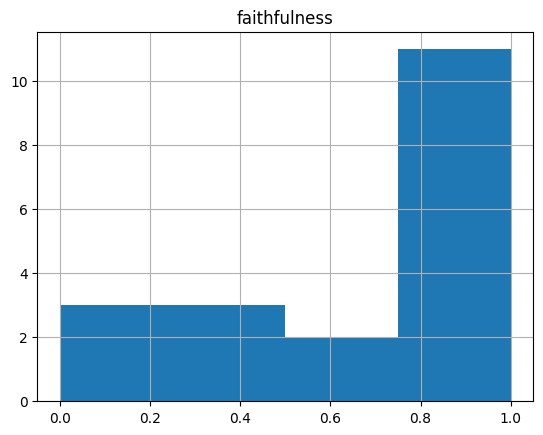

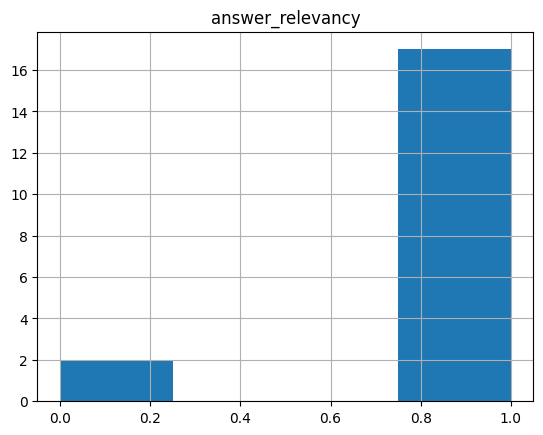

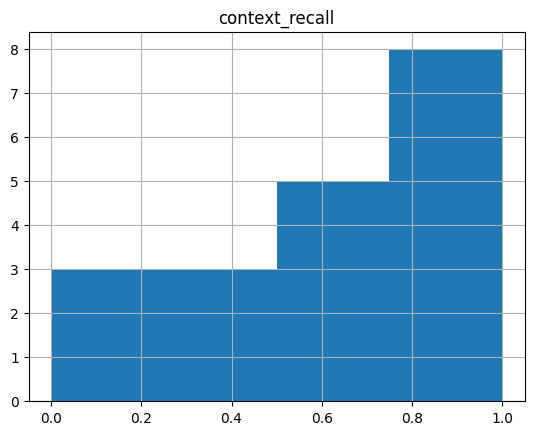

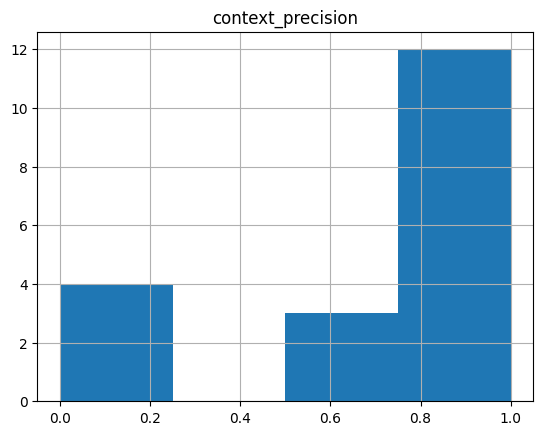

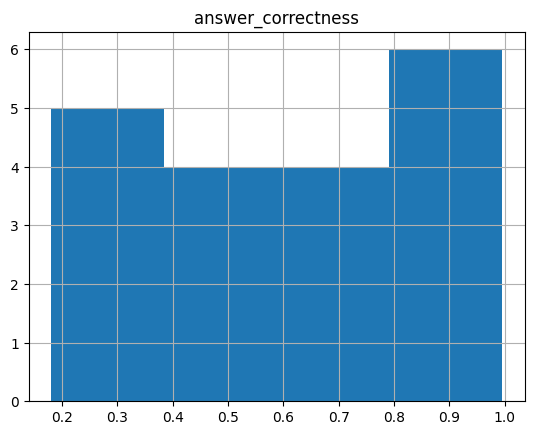

In [39]:
for metric in results_df.columns[4:]:
    #print(m)
    ax = results_df[metric].hist(bins=4)
    ax.set_title(metric)
    plt.show()


## Task : Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #1:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

In [40]:
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

**Answer**

Integrating with the selected OpenAI embedding mode, allowing for easy inference using their API.

In [41]:
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"TE3",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

te3_qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"TE3",
    embedding=te3_embeddings,
)

te3_qdrant_vector_store.add_documents(documents)

['8eeb976b7fae4dff9a62686627ae701f',
 'ae5f0b08a59341dea38fec08392d17eb',
 '28f9d274a6ed4e8cb7bf03744cf96bd3',
 'b5baeb8d25d244df8ae9edd9f5a88741',
 '81c3da38a9c44cde939ccae63f0acd0b',
 '4c9f79dfd3f04522bd92671ce66a8c8d',
 '10551237b2b24439889ebbc2d9940a3e',
 '78513e8a4a96497ebccf6369562bbd5e',
 'dfd96cc545db4e8bb0ed758ece2c555c',
 '195ee169ce5e4dddbdccf9eaa2bc5385',
 '23ffe94b7c504124aae9ec0956eec537',
 '527af804168841448e8b35120156514f',
 'cd3a1c448893425fa1010b50dd0f0391',
 '9aa5a61d6e5045838241c44e3f19c015',
 '2e7821b7b6074a2abd23f84898780078',
 '7bd51a9b4e4a4b189de64d6e43b3e312',
 'e8172ebe8b7e4605a538eace58aad3b8',
 '4f76a90d263f40f98a081b6540ddedd0',
 '698352cab1464deab1cd95c90d08a421',
 'ff5b424f987c46938cef9acc4fe1cc8a',
 '77b83e0c5b8e44b18aaaca05f41eba3a',
 'fd01cf561e114fe9a80d696deb838d33',
 '65d6096c74954277a2eac3ed4d62da68',
 'acd22c68d3904de7a606d08ebb142737',
 '56f2c7453aeb434480c9ef55fac98535',
 '49dd5d412a4f4154a7680810ca4d032c',
 '1039d27f63cd48499a82b7f2b993f473',
 

**Answer**

Steps:
1. Adding a new collection to the existing Qdrant Client (it stores data in memory).
2. Creating a new Qdrant Vector Store to access this collection, specifying the embedding model to be used to create vectors.
3. Populating the new collection (*TE3) be embedding the documents.

These steps are necessary as the modification in our RAG app consists in using a different embedding model. Hence we need to create the Index from scratch or - to be more correct - from chunks as the chunking method remains unchanged.

In [42]:
te3_retriever = te3_qdrant_vector_store.as_retriever()

**Answer**

Converting the store into a retriver.

In [43]:
import re

# Adjusting the Manually Crafted Prompt to the format expected by the LC functions generating RAG QA Chains
base_template = re.sub(r"{question}", "{input}", template)
pretty_print(base_template)

base_prompt = ChatPromptTemplate.from_template(base_template)


You are a helpful assistance. Answer the question using the following context. If you don't know the answer, answer 'I don't know'.

Question:
{input}

Context:
{context}


In [44]:
from langchain.chains.combine_documents import create_stuff_documents_chain

# Using the LC Hub Prompt
document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

# Using the Manually Crafted Prompt
base_document_chain = create_stuff_documents_chain(primary_qa_llm, base_prompt)

In [45]:
pretty_print(str(retrieval_qa_prompt))

input_variables=['context', 'input'] optional_variables=['chat_history'] input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'chat_history': []} metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'retrieval-qa-chat', 'lc_hub_commit_hash': 'b60afb6297176b022244feb83066e10ecadcda7b90423654c4a9d45e7a73cebc'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template='Answer any use questions based solely on the context below:\n\n<context>\n{context}\n</context>')), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]

**Answer**

Creating a chain for "passing a list of Documents to a model" (per documentation), here it means passing the question and the context through the prompt into the model, that is:
```python
{"response": prompt | primary_qa_llm, "context": itemgetter("context")}
```

Important note: to properly evaluate the impact of chaning the embedding model we should leave all other elements of the RAG chain unchanged. However in the original version of this notebook TE3 chain is using `retrieval_qa_prompt` which was not used in the baseline version of the RAG chain.

In [89]:
from langchain.chains import create_retrieval_chain

# Using the LC Hub Prompt
# te3_retrieval_chain = create_retrieval_chain(te3_retriever, document_chain)

# Using the Manually Crafted Prompt
te3_retrieval_chain = create_retrieval_chain(te3_retriever, base_document_chain)

**Answer**

Creating retrieval chain that retrieves documents (using `te3_retriever`) and then passes them on (to `document_chain`) (per documentation), here it is equivalent to:

```python
{"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | document_chain}
```

In [90]:
answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

**Answer**

Generating responses using TE3 chain (the improved app) for the SDG testset.

In [91]:
te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

**Answer**

Creating HuggingFace dataset object for the further processing in Ragas.

In [92]:
te3_advanced_retrieval_results = evaluate(te3_response_dataset_advanced_retrieval, metrics)

Evaluating: 100%|██████████| 95/95 [00:38<00:00,  2.45it/s]


**Answer**

Evaluating with Ragas, against exactly the same metrics and testset as the baseline version of the RAG application.

In [93]:
te3_advanced_retrieval_results

{'faithfulness': 0.6556, 'answer_relevancy': 0.8194, 'context_recall': 0.6228, 'context_precision': 0.6243, 'answer_correctness': 0.5620}

**Answer**

Results of the evaluation of TE3 with the manually crafted prompt:
- Run 1: {'faithfulness': 0.6381, 'answer_relevancy': 0.8186, 'context_recall': 0.6228, 'context_precision': 0.6243, 'answer_correctness': 0.5771}
- Run 2: {'faithfulness': 0.6549, 'answer_relevancy': 0.8189, 'context_recall': 0.6228, 'context_precision': 0.6287, 'answer_correctness': 0.5905}
- Run 3: {'faithfulness': 0.6379, 'answer_relevancy': 0.7691, 'context_recall': 0.6228, 'context_precision': 0.6418, 'answer_correctness': 0.5789}
- Run 4: {'faithfulness': 0.6556, 'answer_relevancy': 0.8194, 'context_recall': 0.6228, 'context_precision': 0.6243, 'answer_correctness': 0.5620}

Results of the evaluation of TE3 with the prompt from the LC Hub:
- Run 1: {'faithfulness': 0.7206, 'answer_relevancy': 0.9714, 'context_recall': 0.6228, 'context_precision': 0.6287, 'answer_correctness': 0.5936}
- Run 2: {'faithfulness': 0.7677, 'answer_relevancy': 0.9736, 'context_recall': 0.5965, 'context_precision': 0.6813, 'answer_correctness': 0.6262}
- Run 3: {'faithfulness': 0.7570, 'answer_relevancy': 0.9724, 'context_recall': 0.6228, 'context_precision': 0.6111, 'answer_correctness': 0.6141}
- Run 4: {'faithfulness': 0.7970, 'answer_relevancy': 0.9720, 'context_recall': 0.6228, 'context_precision': 0.6243, 'answer_correctness': 0.6158}

Comments:
- Gain in answer relevancy seems to result only from prompt selection, embedding model selection has no impact
- Gain in faithfulness of the answer arises from replacing Ada with TE3 embedding model only if the LC hub prompt is being used
- Small gain for answer correctness seems to show up only if the LC Hub prompt is being used
- no benefit for context recall and precision

In [94]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])

df_merged = pd.merge(df_baseline, df_comparison, on='Metric')

df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']

df_merged

,Metric,ADA,TE3,Baseline -> TE3
0,faithfulness,0.651838,0.655567,0.003729
1,answer_relevancy,0.874843,0.819435,-0.055408
2,context_recall,0.609649,0.622807,0.013158
3,context_precision,0.707602,0.624269,-0.083333
4,answer_correctness,0.580432,0.562038,-0.018395


####❓ Question #3:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

**Answer**

Initial results suggested that the answers coming from the app using te3 embedding model are better quality than when using ada embedding model. However after correcting the prompt difference - i.e. using exactly same prompt in both versions of the RAG QA chain the differences become much smaller and conditional on the prompt selection:
- when using the "Manually Crafted Prompt" there are no differences between using Ada versus TE3.
- when using the "LC Hub Prompt" there is a gain for faithfulness and a small gain for correctness when using TE3 versus Ada.

Moreover, independently of any differences in the prompting, the retrival itself receives similar scoring (precision and recall) for both embedding models.

Finally, let me stress the variability in the scores coming from (1) variance in answer generation (2) varience in evaluation, as both are powered by LLM prompting.

To sum up, given the experiment (the selected document and RAG chain) there is only a small gain of using TE3 visible and it is conditional on the form of prompt used during answer generation.

## Task 5: Selecting an Advanced Retriever and Evaluating

#### 🏗️ Activity #2

While the changes that occured due to modifying the embedding model were desirable - you're now tasked with improving `context_recall`, or `context_precision` (or both!).

You'll follow these steps:

1. Reason about this list of Advanced Retrieval methods:
  - [Contextual Compression (Reranker)](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/)
  - [MultiQueryRetriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/)
  - [Parent Document Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/parent_document_retriever/)
2. Select the method you think will be the most performant.
3. Implement that method.
4. Create a LCEL chain that utlizes the new Retriever method.
5. Evaluate this LCEL and compare to the TE3 results.

> NOTE: We will spend more time in Session 14 diving into advanced retrieval methods, this activity is only to serve as a basic introduction to the idea of component-wise improvements and how they might impact metrics.

In [95]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_te3_retriever = MultiQueryRetriever.from_llm(
    retriever=te3_retriever, llm=primary_qa_llm
)

# Using Manually Crafted Prompt
multi_te3_retrieval_chain = create_retrieval_chain(multi_te3_retriever, base_document_chain)

# Using LC Hub Prompt
# multi_te3_retrieval_chain = create_retrieval_chain(multi_te3_retriever, document_chain)

In [96]:
answers = []
contexts = []

for question in test_questions:
  response = multi_te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [97]:
multi_te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [98]:
multi_te3_advanced_retrieval_results = evaluate(multi_te3_response_dataset_advanced_retrieval, metrics)

Evaluating: 100%|██████████| 95/95 [00:38<00:00,  2.48it/s]


In [99]:
multi_te3_advanced_retrieval_results

{'faithfulness': 0.6909, 'answer_relevancy': 0.7227, 'context_recall': 0.7588, 'context_precision': 0.6031, 'answer_correctness': 0.5670}

**Answer**

Using the manually crafted prompt:
- Run 1: {'faithfulness': 0.6749, 'answer_relevancy': 0.6694, 'context_recall': 0.7193, 'context_precision': 0.6141, 'answer_correctness': 0.5609}
- Run 2: {'faithfulness': 0.5941, 'answer_relevancy': 0.7227, 'context_recall': 0.7105, 'context_precision': 0.6170, 'answer_correctness': 0.5382}
- Run 3: {'faithfulness': 0.6909, 'answer_relevancy': 0.7227, 'context_recall': 0.7588, 'context_precision': 0.6031, 'answer_correctness': 0.5670}

Using the LC Hub prompt:
- Run 1: {'faithfulness': 0.8361, 'answer_relevancy': 0.9686, 'context_recall': 0.6930, 'context_precision': 0.6053, 'answer_correctness': 0.5998}

In [100]:
# df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison_2 = pd.DataFrame(list(multi_te3_advanced_retrieval_results.items()), columns=['Metric', 'multi_TE3'])

df_merged = pd.merge(df_baseline, df_comparison, on='Metric')
df_merged = pd.merge(df_merged, df_comparison_2, on='Metric')

df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']
df_merged['Baseline -> multi_TE3'] = df_merged['multi_TE3'] - df_merged['ADA']

df_merged

,Metric,ADA,TE3,multi_TE3,Baseline -> TE3,Baseline -> multi_TE3
0,faithfulness,0.651838,0.655567,0.690913,0.003729,0.039075
1,answer_relevancy,0.874843,0.819435,0.722664,-0.055408,-0.152179
2,context_recall,0.609649,0.622807,0.758772,0.013158,0.149123
3,context_precision,0.707602,0.624269,0.603133,-0.083333,-0.104470
4,answer_correctness,0.580432,0.562038,0.566954,-0.018395,-0.013478


**Comments**
- Context recall gets 10 - 15 p.p. improvement.
- When using LC Hub Prompt, we see significant gain in faithfulness
- When using the Manually Crafted Prompt, we see only a small gain in faithfulness

#### 🚧 BONUS CHALLENGE 🚧

> NOTE: Completing this challenge will provide full marks on the assignment, regardless of the complete of the notebook. You do not need to complete this in the notebook for full marks.

##### **MINIMUM REQUIREMENTS**:

1. Baseline `LCEL RAG` Application using `NAIVE RETRIEVAL`
2. Baseline Evaluation using `RAGAS METRICS`
  - [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
  - [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
  - [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
  - [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
  - [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)
3. Implement a `SEMANTIC CHUNKING STRATEGY`.
4. Create an `LCEL RAG` Application using `SEMANTIC CHUNKING` with `NAIVE RETRIEVAL`.
5. Compare and contrast results.

##### **SEMANTIC CHUNKING REQUIREMENTS**:

Chunk semantically similar (based on designed threshold) sentences, and then paragraphs, greedily, up to a maximum chunk size. Minimum chunk size is a single sentence.

Have fun!